# Tutorial Part 4: Introduction to Graph Convolutions

In the previous sections of the tutorial, we learned about `Dataset` and `Model` objects. We learned how to load some data into DeepChem from files on disk and also learned some basic facts about molecular data handling. We then dove into some basic deep learning architectures. However, until now, we stuck with vanilla deep learning architectures and didn't really consider how to handle deep architectures specifically engineered to work with life science data.

In this tutorial, we'll change that by going a little deeper and learn about "graph convolutions." These are one of the most powerful deep learning tools for working with molecular data. The reason for this is that molecules can be naturally viewed as graphs.

![Molecular Graph](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/basic_graphs.gif?raw=1)

Note how standard chemical diagrams of the sort we're used to from high school lend themselves naturally to visualizing molecules as graphs. In the remainder of this tutorial, we'll dig into this relationship in significantly more detail. This will let us get an in-the guts understanding of how these systems work.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/04_Introduction_to_Graph_Convolutions.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3489  100  3489    0     0   126k      0 --:--:-- --:--:-- --:--:--  126k


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
all packages is already installed


# conda environments:
#
base                  *  /root/miniconda



In [2]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

'2.4.0-rc1.dev'

Ok now that we have our environment installed, we can actually import the core `GraphConvModel` that we'll use through this tutorial.

In [3]:
import deepchem as dc
from deepchem.models.graph_models import GraphConvModel

Now, let's use the MoleculeNet suite  to load the Tox21 dataset. We need to make sure to process the data in a way that graph convolutional networks can use For that, we make sure to set the featurizer option to 'GraphConv'. The MoleculeNet call will return a training set, a validation set, and a test set for us to use. The call also returns `transformers`, a list of data transformations that were applied to preprocess the dataset. (Most deep networks are quite finicky and require a set of data transformations to ensure that training proceeds stably.)

In [4]:
# Load Tox21 dataset
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv', reload=False)
train_dataset, valid_dataset, test_dataset = tox21_datasets

smiles_field is deprecated and will be removed in a future version of DeepChem. Use feature_field instead.
/usr/local/lib/python3.6/dist-packages/deepchem/data/data_loader.py:198: FutureWarning: featurize() is deprecated and has been renamed to create_dataset(). featurize() will be removed in DeepChem 3.0
  FutureWarning)


Let's now train a graph convolutional network on this dataset. DeepChem has the class `GraphConvModel` that wraps a standard graph convolutional architecture underneath the hood for user convenience. Let's instantiate an object of this class and train it on our dataset.

In [5]:
n_tasks = len(tox21_tasks)
model = GraphConvModel(n_tasks, batch_size=50, mode='classification')

num_epochs = 10
losses = []
for i in range(num_epochs):
 loss = model.fit(train_dataset, nb_epoch=1)
 print("Epoch %d loss: %f" % (i, loss))
 losses.append(loss)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0 loss: 0.198352
Epoch 1 loss: 0.183952
Epoch 2 loss: 0.173609
Epoch 3 loss: 0.120326
Epoch 4 loss: 0.164240
Epoch 5 loss: 0.152436
Epoch 6 loss: 0.144272
Epoch 7 loss: 0.141582
Epoch 8 loss: 0.143059
Epoch 9 loss: 0.136201


Let's plot these losses so we can take a look at how the loss changes over the process of training.

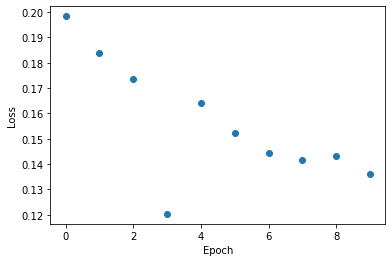

In [6]:
import matplotlib.pyplot as plot

plot.ylabel("Loss")
plot.xlabel("Epoch")
x = range(num_epochs)
y = losses
plot.scatter(x, y)
plot.show()

We see that the losses fall nicely and give us stable learning.

Let's try to evaluate the performance of the model we've trained. For this, we need to define a metric, a measure of model performance. `dc.metrics` holds a collection of metrics already. For this dataset, it is standard to use the ROC-AUC score, the area under the receiver operating characteristic curve (which measures the tradeoff between precision and recall). Luckily, the ROC-AUC score is already available in DeepChem. 

To measure the performance of the model under this metric, we can use the convenience function `model.evaluate()`.

In [7]:
import numpy as np
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores["mean-roc_auc_score"])
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores["mean-roc_auc_score"])

Evaluating model


n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ignored.
n_samples is a deprecated argument which is ig

Training ROC-AUC Score: 0.883849
Validation ROC-AUC Score: 0.789217


What's going on under the hood? Could we build `GraphConvModel` ourselves? Of course! The first step is to define the inputs to our model. Conceptually, graph convolutions just require the structure of the molecule in question and a vector of features for every atom that describes the local chemical environment. However in practice, due to TensorFlow's limitations as a general programming environment, we have to have some auxiliary information as well preprocessed.

`atom_features` holds a feature vector of length 75 for each atom. The other inputs are required to support minibatching in TensorFlow. `degree_slice` is an indexing convenience that makes it easy to locate atoms from all molecules with a given degree. `membership` determines the membership of atoms in molecules (atom `i` belongs to molecule `membership[i]`). `deg_adjs` is a list that contains adjacency lists grouped by atom degree. For more details, check out the [code](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/mol_graphs.py).

To define feature inputs with Keras, we use the `Input` layer. Conceptually, a model is a mathematical graph composed of layer objects. `Input` layers have to be the root nodes of the graph since they consitute inputs.

In [8]:
import tensorflow as tf
import tensorflow.keras.layers as layers

atom_features = layers.Input(shape=(75,))
degree_slice = layers.Input(shape=(2,), dtype=tf.int32)
membership = layers.Input(shape=tuple(), dtype=tf.int32)

deg_adjs = []
for i in range(0, 10 + 1):
    deg_adj = layers.Input(shape=(i+1,), dtype=tf.int32)
    deg_adjs.append(deg_adj)

Let's now implement the body of the graph convolutional network. DeepChem has a number of layers that encode various graph operations. Namely, the `GraphConv`, `GraphPool` and `GraphGather` layers. We will also apply standard neural network layers such as `Dense` and `BatchNormalization`.

The layers we're adding effect a "feature transformation" that will create one vector for each molecule.

In [9]:
# from deepchem.models.layers import GraphConv, GraphPool, GraphGather

# batch_size = 50

# gc1 = GraphConv(64, activation_fn=tf.nn.relu)([atom_features, degree_slice, membership] + deg_adjs)
# batch_norm1 = layers.BatchNormalization()(gc1)
# gp1 = GraphPool()([batch_norm1, degree_slice, membership] + deg_adjs)
# gc2 = GraphConv(64, activation_fn=tf.nn.relu)([gp1, degree_slice, membership] + deg_adjs)
# batch_norm2 = layers.BatchNormalization()(gc2)
# gp2 = GraphPool()([batch_norm2, degree_slice, membership] + deg_adjs)
# dense = layers.Dense(128, activation=tf.nn.relu)(gp2)
# batch_norm3 = layers.BatchNormalization()(dense)
# readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)([batch_norm3, degree_slice, membership] + deg_adjs)
# logits = layers.Reshape((n_tasks, 2))(layers.Dense(n_tasks*2)(readout))
# softmax = layers.Softmax()(logits)

Let's now create the `KerasModel`. To do that we specify the inputs and outputs to the model. We also have to define a loss for the model which tells the network the objective to minimize during training.

In [10]:
# inputs = [atom_features, degree_slice, membership] + deg_adjs
# outputs = [softmax]
# keras_model = tf.keras.Model(inputs=inputs, outputs=outputs)
# loss = dc.models.losses.CategoricalCrossEntropy()
# model = dc.models.KerasModel(keras_model, loss=loss)

Now that we've successfully defined our graph convolutional model, we need to train it. We can call `fit()`, but we need to make sure that each minibatch of data populates all the `Input` objects that we've created. For this, we need to create a Python generator that given a batch of data generates the lists of inputs, labels, and weights whose values are Numpy arrays we'd like to use for this step of training.

In [11]:
# from deepchem.metrics import to_one_hot
# from deepchem.feat.mol_graphs import ConvMol

# def data_generator(dataset, epochs=1, predict=False, pad_batches=True):
#   for epoch in range(epochs):
#     for ind, (X_b, y_b, w_b, ids_b) in enumerate(
#         dataset.iterbatches(
#             batch_size, pad_batches=pad_batches, deterministic=True)):
#       multiConvMol = ConvMol.agglomerate_mols(X_b)
#       inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
#       for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
#         inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
#       labels = [to_one_hot(y_b.flatten(), 2).reshape(-1, n_tasks, 2)]
#       weights = [w_b]
#       yield (inputs, labels, weights)

Now, we can train the model using `KerasModel.fit_generator(generator)` which will use the generator we've defined to train the model.

In [12]:
# num_epochs = 10
# losses = []
# for i in range(num_epochs):
#   loss = model.fit_generator(data_generator(train_dataset, epochs=1))
#   print("Epoch %d loss: %f" % (i, loss))
#   losses.append(loss)

Let's now plot these losses and take a quick look.

In [13]:
# plot.title("Keras Version")
# plot.ylabel("Loss")
# plot.xlabel("Epoch")
# x = range(num_epochs)
# y = losses
# plot.scatter(x, y)
# plot.show()

Now that we have trained our graph convolutional method, let's evaluate its performance. We again have to use our defined generator to evaluate model performance.

In [14]:
# metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

# def reshape_y_pred(y_true, y_pred):
#     """
#     GraphConv always pads batches, so we need to remove the predictions
#     for the padding samples.  Also, it outputs two values for each task
#     (probabilities of positive and negative), but we only want the positive
#     probability.
#     """
#     n_samples = len(y_true)
#     return y_pred[:n_samples, :, 1]
    

# print("Evaluating model")
# train_predictions = model.predict_on_generator(data_generator(train_dataset, predict=True))
# train_predictions = reshape_y_pred(train_dataset.y, train_predictions)
# train_scores = metric.compute_metric(train_dataset.y, train_predictions, train_dataset.w)
# print("Training ROC-AUC Score: %f" % train_scores)

# valid_predictions = model.predict_on_generator(data_generator(valid_dataset, predict=True))
# valid_predictions = reshape_y_pred(valid_dataset.y, valid_predictions)
# valid_scores = metric.compute_metric(valid_dataset.y, valid_predictions, valid_dataset.w)
# print("Valid ROC-AUC Score: %f" % valid_scores)

Success! The model we've constructed behaves nearly identically to `GraphConvModel`. If you're looking to build your own custom models, you can follow the example we've provided here to do so. We hope to see exciting constructions from your end soon!

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!